In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import axis
from core.normalize import *
from plotmodules.norm_plots import *
from core.test_model import test_abundance

ROSMAP_PATH = 'ROSMAP_clinical.csv'
CT_COUNTS_META_PATH = 'ct_counts_public_meta.h5ad'

ROSMAP_data = pd.read_csv(ROSMAP_PATH)
ct_counts_metadata = ad.read_h5ad(CT_COUNTS_META_PATH)

ROSMAP_data = ROSMAP_data.convert_dtypes()
ct_counts_metadata.obs = ct_counts_metadata.obs.convert_dtypes()

In [2]:
from core.outliers import *

calculate_ct_per_median(ct_counts_metadata, 'Exc RELN CHD7', normalize_first=True, column_name='RELN_p_ctm', replace_infs=99999)

ct_counts_metadata.obs

Encountered NaN: 
avg_metric=0.000, ct_count=0.000 => count/avg_metric=nan
Replacing with: 0
Encountered infinity: 
avg_metric=0.000, ct_count=8465.957 => count/avg_metric=inf
Replacing with: 99999
Encountered infinity: 
avg_metric=0.000, ct_count=9043.849 => count/avg_metric=inf
Replacing with: 99999
Encountered infinity: 
avg_metric=0.000, ct_count=8772.727 => count/avg_metric=inf
Replacing with: 99999
Encountered infinity: 
avg_metric=0.000, ct_count=9113.701 => count/avg_metric=inf
Replacing with: 99999
Encountered infinity: 
avg_metric=0.000, ct_count=9009.959 => count/avg_metric=inf
Replacing with: 99999
Encountered NaN: 
avg_metric=0.000, ct_count=0.000 => count/avg_metric=nan
Replacing with: 0
Encountered infinity: 
avg_metric=0.000, ct_count=8889.606 => count/avg_metric=inf
Replacing with: 99999
Encountered infinity: 
avg_metric=0.000, ct_count=7774.618 => count/avg_metric=inf
Replacing with: 99999
Encountered infinity: 
avg_metric=0.000, ct_count=6930.693 => count/avg_metric=

/home/jacob/Documents/BEP/bsc-thesis-scripts/outliers.py:37: RuntimeWarning: invalid value encountered in scalar divide
  cpm = ct_count / avg_metric
/home/jacob/Documents/BEP/bsc-thesis-scripts/outliers.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  cpm = ct_count / avg_metric


,Study,msex,educ,race,spanish,apoe_genotype,age_at_visit_max,age_first_ad_dx,age_death,cts_mmse30_first_ad_dx,cts_mmse30_lv,pmi,braaksc,ceradsc,cogdx,dcfdx_lv,individualID,projid,RELN_p_ctm
projid,,,,,,,,,,,,,,,,,,,
1211411,ROS,1,12,1,2,<NA>,85.248459958932244,NaN,85.549623545516766,<NA>,24.0,6.5,1,4,4,4,R2626559,1211411,3.500000
2899847,MAP,1,14,1,2,33,73.489390828199859,NaN,74.450376454483234,<NA>,27.0,7.016667,2,2,3,3,R9936070,2899847,1.142857
3713990,MAP,1,12,1,2,33,87.668720054757017,NaN,87.928815879534568,<NA>,30.0,4.333333,4,2,1,1,R2367199,3713990,0.578947
3889845,MAP,0,13,1,2,34,90+,NaN,90+,<NA>,22.0,6.916667,2,1,2,2,R9891381,3889845,20.098039
6107196,MAP,1,15,1,2,33,90+,NaN,90+,<NA>,22.0,4.166667,5,1,4,4,R9033345,6107196,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94974890,MAP,0,12,1,2,33,77.700205338809042,NaN,78.190280629705683,<NA>,27.0,7.083333,1,2,2,2,R9507497,94974890,1.000000
95491648,MAP,1,19,1,2,33,85.587953456536624,NaN,85.796030116358665,<NA>,27.0,5.583333,3,4,1,1,R5259690,95491648,1.875000
95919181,MAP,1,16,1,2,33,85.352498288843265,NaN,85.826146475017111,<NA>,28.0,3.25,3,2,2,2,R1977848,95919181,1.000000


In [3]:
# Get the threshold value
count_filter = ct_counts_metadata.obs['RELN_p_ctm'] > 10

def _categorize_RELN(value) -> str:
    r: str
    if value < 10:
        r = 'lowRELN'
    elif 10 <= value < 1000:
        r = 'midRELN'
    elif value >= 1000:
        r = 'highRELN'
    return r

cogdx_map = {1: 'H', 2: 'M', 3: 'M', 4: 'AD', 5: 'AD', 6: 'O'}

high_RELN_samples = ct_counts_metadata.obs[count_filter]
ct_counts_metadata.obs['RELN_cat'] = ct_counts_metadata.obs.apply(lambda row: _categorize_RELN(row['RELN_p_ctm']), axis=1)
ct_counts_metadata.obs['cog_cat'] = ct_counts_metadata.obs.apply(lambda row: cogdx_map[row['cogdx']], axis=1)

RELN_contingency = ct_counts_metadata.obs.value_counts(['RELN_cat', 'cog_cat'])
RELN_contingency

RELN_cat  cog_cat
lowRELN   AD         150
          H          138
          M          101
          O           11
midRELN   H            6
          M            6
highRELN  AD           5
midRELN   AD           5
highRELN  M            3
          H            2
Name: count, dtype: int64

In [4]:
# Chi squared

from scipy.stats import chisquare

res = chisquare(RELN_contingency['highRELN'])
res.pvalue


0.4965853037914095

/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


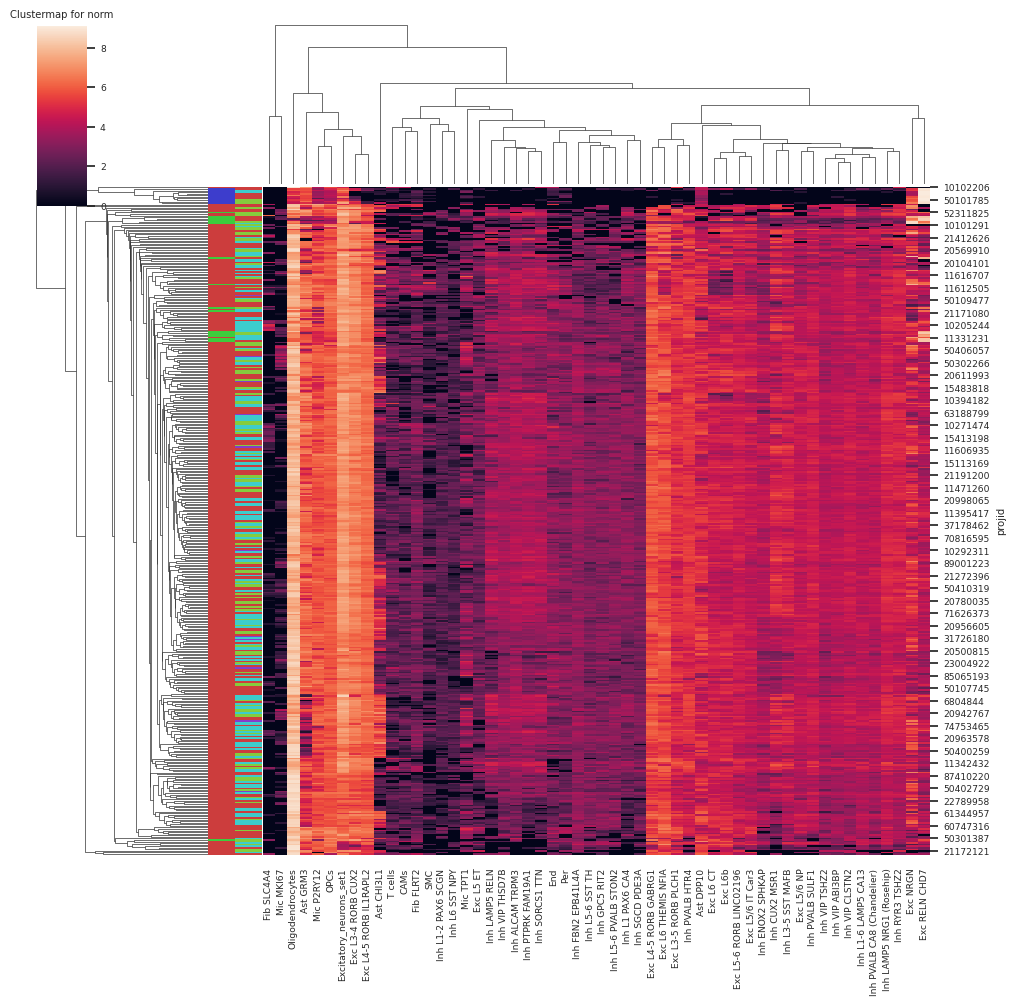

In [5]:
lut = dict(zip(ct_counts_metadata.obs['RELN_cat'].unique(), "rbg"))
row_colors = ct_counts_metadata.obs['RELN_cat'].map(lut)
normalize_l1(ct_counts_metadata)
generate_clustermap(ct_counts_metadata, 'norm', color_by=['RELN_cat', 'cog_cat'])